<a href="https://colab.research.google.com/github/Bunrealbo/portfolio-formation-with-ltsm/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Đường dẫn đến thư mục chứa dữ liệu trong Google Drive
data_path = '/content/drive/MyDrive/data VN30 5 11 2024/data_final/'  # Thay 'your_folder_name' bằng tên thư mục

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install PyPortfolioOpt

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Lấy danh sách tệp CSV trong thư mục
file_names = [f for f in os.listdir(data_path) if f.endswith('.csv')]

all_data = {}
for file in file_names:
    df = pd.read_csv(os.path.join(data_path, file))
    stock_name = file.split('.')[0]
    all_data[stock_name] = df

In [ ]:
# Tạo DataFrame tổng hợp
merged_data = pd.DataFrame()
for stock, df in all_data.items():
    df['Stock'] = stock
    merged_data = pd.concat([merged_data, df])
merged_data = merged_data.drop(columns=['Unnamed: 0'])
# Chuyển đổi cột ngày thành định dạng datetime
merged_data['time'] = pd.to_datetime(merged_data['time'])
merged_data.set_index('time', inplace=True)
print(merged_data)

               open     high      low    close     volume Stock
time                                                           
2022-10-21  1055.34  1055.34  1002.09  1010.57  190652861  VN30
2022-10-24  1011.54  1013.24   961.79   973.88  169908119  VN30
2022-10-25   971.29  1006.69   950.19   991.52  180001549  VN30
2022-10-26   995.73   999.59   979.40   990.41   74337124  VN30
2022-10-27   992.95  1028.50   986.54  1028.50  158331052  VN30
...             ...      ...      ...      ...        ...   ...
2024-10-15    19.15    19.20    18.80    18.80    6687785   VRE
2024-10-16    18.80    18.90    18.65    18.70    4187068   VRE
2024-10-17    18.70    18.85    18.60    18.75    5002318   VRE
2024-10-18    18.95    19.10    18.75    18.75    5086581   VRE
2024-10-21    18.80    19.30    18.75    19.10   11492821   VRE

[15469 rows x 6 columns]


In [ ]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
merged_data[['open', 'high', 'low', 'close', 'volume']] = scaler.fit_transform(
    merged_data[['open', 'high', 'low', 'close', 'volume']]
)
merged_data


,open,high,low,close,volume,Stock
time,,,,,,
2022-10-21,0.770402,0.767135,0.735352,0.740300,0.408784,VN30
2022-10-24,0.738249,0.736337,0.705607,0.713255,0.364301,VN30
2022-10-25,0.708703,0.731545,0.697045,0.726258,0.385945,VN30
2022-10-26,0.726643,0.726351,0.718605,0.725439,0.159367,VN30
2022-10-27,0.724603,0.747500,0.723875,0.753516,0.339476,VN30
...,...,...,...,...,...,...
2024-10-15,0.009756,0.009152,0.009581,0.009251,0.014306,VRE
2024-10-16,0.009499,0.008932,0.009470,0.009177,0.008944,VRE
2024-10-17,0.009426,0.008896,0.009433,0.009214,0.010692,VRE


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Chuẩn bị dữ liệu cho LSTM chỉ dùng giá đóng cửa và tạo cột độ trễ
def create_lagged_data(data, lag):
    """
    Tạo dữ liệu độ trễ.
    data: Chuỗi thời gian (một cột duy nhất, giá đóng cửa).
    lag: Số độ trễ cần sử dụng.
    """
    x, y = [], []
    for i in range(len(data) - lag):
        x.append(data[i:i+lag])  # Lấy các giá trị trong khoảng [i:i+lag]
        y.append(data[i+lag])   # Giá trị cần dự đoán (ngày tiếp theo sau lag)
    return np.array(x), np.array(y)

lag = 60  # Số độ trễ

close_data = merged_data.loc[merged_data['Stock'] == 'ACB']['close'].values

# Tạo dữ liệu với độ trễ
x_train, y_train = create_lagged_data(close_data, lag)

# Định hình lại x_train cho phù hợp với input LSTM (3 chiều)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lag, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Dự đoán giá
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 3.4079e-05 - val_loss: 3.1215e-05
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 8.7036e-06 - val_loss: 8.3834e-06
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 5.1311e-06 - val_loss: 5.0724e-06
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 4.7758e-06 - val_loss: 6.2066e-06
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 3.2018e-06 - val_loss: 2.0790e-05
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 3.3811e-06 - val_loss: 1.6163e-05
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 2.8146e-06 - val_loss: 1.9220e-05
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 3.0284e-06 - val_loss: 9.6483e-06
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 2.7300e-06 - val_loss: 1.2716e-05
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 3.0001e-06 - val_loss: 7.3616e-06
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 2.0245

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


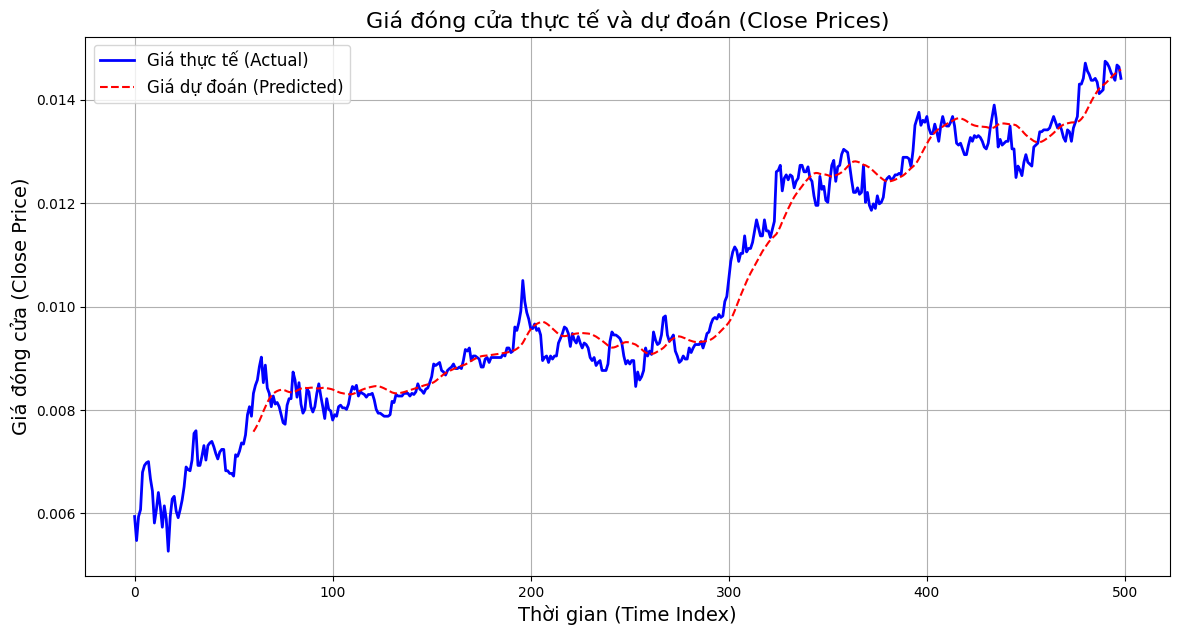

In [ ]:
import matplotlib.pyplot as plt

# Dự đoán trên dữ liệu huấn luyện
y_pred_train = model.predict(x_train)

# Vẽ biểu đồ
plt.figure(figsize=(14, 7))

# Giá trị đóng cửa thực tế
plt.plot(range(len(close_data)), close_data, label="Giá thực tế (Actual)", color='blue', linewidth=2)

# Giá trị dự đoán (bắt đầu từ độ trễ để khớp trục thời gian)
plt.plot(range(lag, len(close_data)), y_pred_train, label="Giá dự đoán (Predicted)", color='red', linestyle='--')

# Các tùy chỉnh biểu đồ
plt.title("Giá đóng cửa thực tế và dự đoán (Close Prices)", fontsize=16)
plt.xlabel("Thời gian (Time Index)", fontsize=14)
plt.ylabel("Giá đóng cửa (Close Price)", fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

# Tính lợi suất hàng ngày
returns = merged_data.pivot(columns='Stock', values='close').pct_change()
# Loại bỏ hàng có giá trị vô hạn hoặc NaN (nếu có)
returns = returns.dropna(how='all')  # Loại bỏ các hàng toàn bộ NaN
print(returns)

returns = returns[~np.isinf(returns).any(axis=1)]  # Loại bỏ các hàng chứa vô hạn
print(returns)


Stock            ACB       BCM       BID       BVH       CTG       FPT  \
time                                                                     
2022-10-24 -0.078164 -0.019495 -0.088183 -0.003709 -0.044935 -0.042735   
2022-10-25  0.084791  0.000000  0.041103  0.051050  0.103668  0.033537   
2022-10-26  0.022333 -0.001362  0.016256  0.027827 -0.002890  0.009271   
2022-10-27  0.118932 -0.002591  0.089122  0.040610  0.100000  0.030689   
2022-10-28  0.019523  0.001231 -0.003777 -0.010880  0.005929 -0.011951   
...              ...       ...       ...       ...       ...       ...   
2024-10-15 -0.005076 -0.008193  0.013905 -0.007947  0.003356 -0.004568   
2024-10-16 -0.005102  0.000000 -0.003429  0.002670  0.005017 -0.005354   
2024-10-17  0.020513 -0.004791  0.010321  0.005326  0.008319  0.005383   
2024-10-18 -0.002513  0.000000  0.000000  0.000000 -0.009901  0.000000   
2024-10-21 -0.015113 -0.016434 -0.014756 -0.006623 -0.025000 -0.011472   

Stock            GAS       GVR       

In [ ]:
# Tính lợi suất kỳ vọng và ma trận hiệp phương sai
mean_returns = mean_historical_return(returns)
cov_matrix = CovarianceShrinkage(returns).ledoit_wolf()
print(cov_matrix)

/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/expected_returns.py:36: UserWarning: Some returns are infinite. Please check your price data.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:53: RuntimeWarning: invalid value encountered in reduce
  return umr_prod(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis

ValueError: Input contains NaN.

In [ ]:
# Tối ưu hóa danh mục đầu tư
ef = EfficientFrontier(mean_returns, cov_matrix)
weights = ef.max_sharpe()  # Tối ưu Sharpe ratio
cleaned_weights = ef.clean_weights()

# Hiển thị kết quả
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
import numpy as np

# ... (rest of your data loading and preprocessing code)

# Tính lợi suất hàng ngày
returns = merged_data.pivot(columns='Stock', values='close').pct_change()

# Loại bỏ hàng có giá trị vô hạn hoặc NaN (nếu có)
returns = returns.dropna(how='all')
returns = returns[~np.isinf(returns).any(axis=1)]

# Thay thế các giá trị NaN bằng interpolation with a stricter limit
returns = returns.interpolate(method='linear', limit_direction='both', limit=5)

# **Additional Checks and Handling**
# 1. Check for infinite values after interpolation
returns = returns.replace([np.inf, -np.inf], np.nan)

# 2. Drop columns with too many NaNs after interpolation
returns = returns.dropna(axis=1, thresh=len(returns) * 0.8) # Drop cols with > 20% NaNs

# 3. Fill remaining NaNs with 0 (if any)
returns = returns.fillna(0)

# Tính lợi suất kỳ vọng và ma trận hiệp phương sai
mean_returns = mean_historical_return(returns)
cov_matrix = sample_cov(returns)

# Tối ưu hóa danh mục đầu tư (Mean-Variance Optimization)
ef = EfficientFrontier(mean_returns, cov_matrix)
weights = ef.min_volatility()

cleaned_weights = ef.clean_weights()

# Hiển thị kết quả
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

In [ ]:
# Kiểm tra tổng quát các thống kê dữ liệu
print(returns.describe())

# Kiểm tra cột nào có độ lệch chuẩn bằng 0 (thiếu biến thiên)
print(returns.std())
print(returns.std()[returns.std() == 0])


In [ ]:
import matplotlib.pyplot as plt

# Lợi nhuận tích lũy
cumulative_returns = (returns + 1).cumprod()
cumulative_returns.plot(figsize=(10, 6))
plt.title("Cumulative Returns")
plt.show()


In [ ]:
import scipy.optimize as sco

def Portfolio_volatility(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 0.1) for _ in range(num_assets))  # Tỷ trọng tối đa 10%
    result = sco.minimize(Portfolio_volatility, num_assets*[1/num_assets],
                          args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [ ]:
# Chọn 10 cổ phiếu dự đoán lợi suất cao nhất
buy_stock = df_predict.iloc[-1].rank(ascending=False).sort_values()[:10].index.tolist()

# Tính trung bình lợi suất và ma trận hiệp phương sai
mean_return = ret_TW150[buy_stock].mean()
cov_matrix = ret_TW150[buy_stock].cov()

# Tính tỷ trọng danh mục
weights = min_variance(mean_return, cov_matrix)['x']


In [ ]:
portfolio_value = 1000  # Giá trị danh mục ban đầu
portfolio_history = [portfolio_value]

for i in range(len(df_predict)):
    # Chọn 10 cổ phiếu dự đoán cao nhất
    buy_stock = df_predict.iloc[i].rank(ascending=False).sort_values()[:10].index.tolist()

    # Tính toán tỷ trọng danh mục
    t1 = TW150.index.get_loc(df_predict.index[i])
    mean_return = ret_TW150.iloc[t1-240:t1][buy_stock].mean()
    cov_matrix = ret_TW150.iloc[t1-240:t1][buy_stock].cov()
    weights = min_variance(mean_return, cov_matrix)['x']

    # Tính giá trị danh mục
    buy_price = TW150.iloc[t1][buy_stock]
    sell_price = TW150.iloc[t1+60][buy_stock]
    portfolio_value += np.sum(weights * (sell_price - buy_price) / buy_price * portfolio_value)
    portfolio_history.append(portfolio_value)
